<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/AE_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE (AutoEncoder) & Anomaly Detection

## 1. Load dataset

## 2. Import python libraries and define util functions

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to plot a line graph for loss history after model training
def plot_loss(loss_train_history, title=None):

    plt.plot(loss_train_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train data'], loc=0)
    # plt.show()

In [ ]:
set_seed(0)

## 3. Check dataset

In [ ]:
path = './dataset/data_3000/22.5651.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

## 4. Convert images into trainable data

In [ ]:
# image size = 56 x 56, 3000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './dataset/data_3000/'

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
    X.append(img_read(src,file)/255.)  # normalize the image
    Y.append(1)  # normal label: 1

# convert the data to array
X = np.array(X)
Y = np.array(Y)

# check the shape of the data
print('X.shape:',np.shape(X),'Y.shape:',np.shape(Y))

In [ ]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X[i, :, :],cmap = plt.cm.bone)
    ax.set_title(f"Y {Y[i]:.2f}")
    ax.axis('off')
plt.show()

## 5. Define dataloader

In [ ]:
# split the data into 80% training set and 20% test set (test set can be considered as validation)
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)

# print the shapes and types of the training and test datasets
print(np.shape(train_images), np.shape(test_images))
print(type(train_images), type(test_images))

print(np.shape(train_labels),np.shape(test_labels))
print(type(train_labels), type(test_labels))

# reshape the (image,image) images into (image*image,) size vectors
train_images = train_images.reshape((len(train_images), np.prod(train_images.shape[1:]))).astype('float32')
test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(train_images),np.shape(test_images)))

# convert data to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.float32) # don't need to use labels
test_images = torch.tensor(test_images, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float32)   # don't need to use labels

## 6. Set to model architecture

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(image_size, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, h_dim),
            nn.ReLU())

        self.decoder = nn. Sequential(
            nn.Linear(h_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, image_size),
            nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

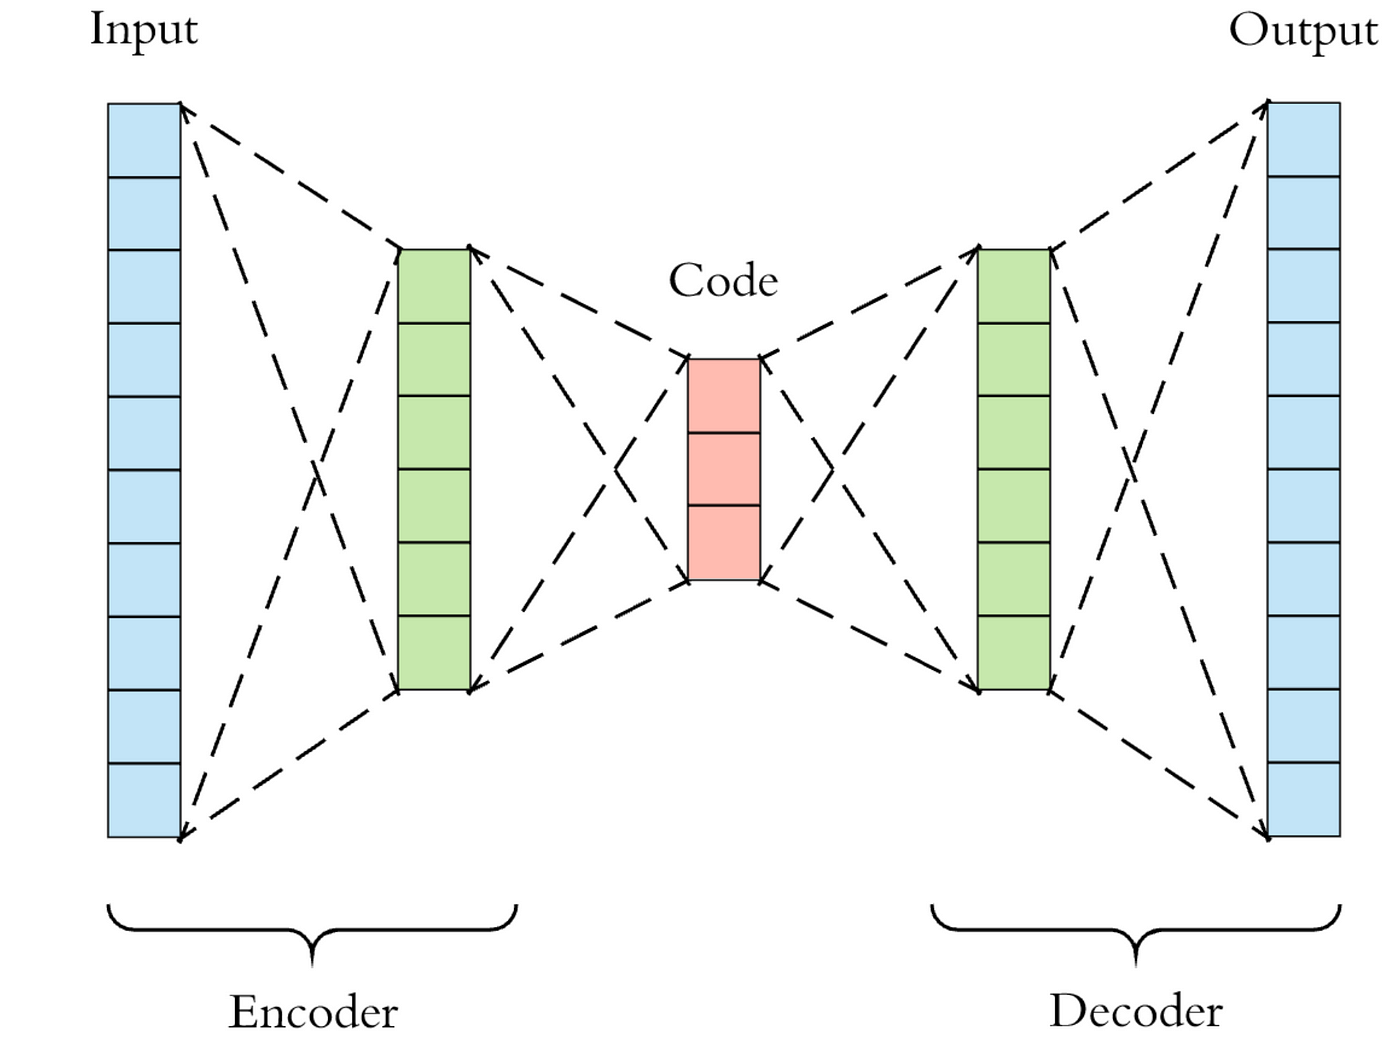

## 7. Set model hyperparameters

In [ ]:
# model architecture parameters
image_size = np.shape(train_images[0])[0]  # (fixed) input size
mid_dim = 512  # hidden layer(middle) dimension
h_dim = 20  # hidden layer(latent) dimension

# training parameters
num_epochs = 200
batch_size = 20
learning_rate = 1e-3

In [ ]:
autoencoder = Autoencoder().to(device)

# print the model's summary
summary(autoencoder, (image_size,))  # input shape: (channels, height, width)

autoencoder

## 8. Train model

In [ ]:
# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images, train_images)  # labels are not needed in autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# lists to track training and validation history
loss_train_history = []

# train the model
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        output = autoencoder(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # calculate average metrics for the training set
    average_loss_train = total_loss / len(train_loader)

    # save training metrics
    loss_train_history.append(average_loss_train)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train}")

    # perform inference every XX epochs
    if (epoch + 1) % 50 == 0 or epoch == 0:
        autoencoder.eval()
        recon_x_test = autoencoder(test_images)

        n = 10  # how many images to display
        plt.figure(figsize=(15, 4)) # figure size

        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(test_images.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Input{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Recon{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
        plt.show()
        autoencoder.train()  # switch back to training mode

# save the model
torch.save(autoencoder.state_dict(), 'AE_model.pth')

In [ ]:
# graph visualization
plot_loss(loss_train_history, 'Learning Curve')  # loss variation over epochs during training
plt.show()

## 9. Load & Evaluate model

- Compare the orginial image and the reconstructed image

In [ ]:
autoencoder.eval().to(device)

# proceed reconstruction of the bracket images through the trained autoencoder model
recon_x_test = autoencoder(test_images)

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images.cpu()[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Input"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Recon"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 10. Anomaly detection test

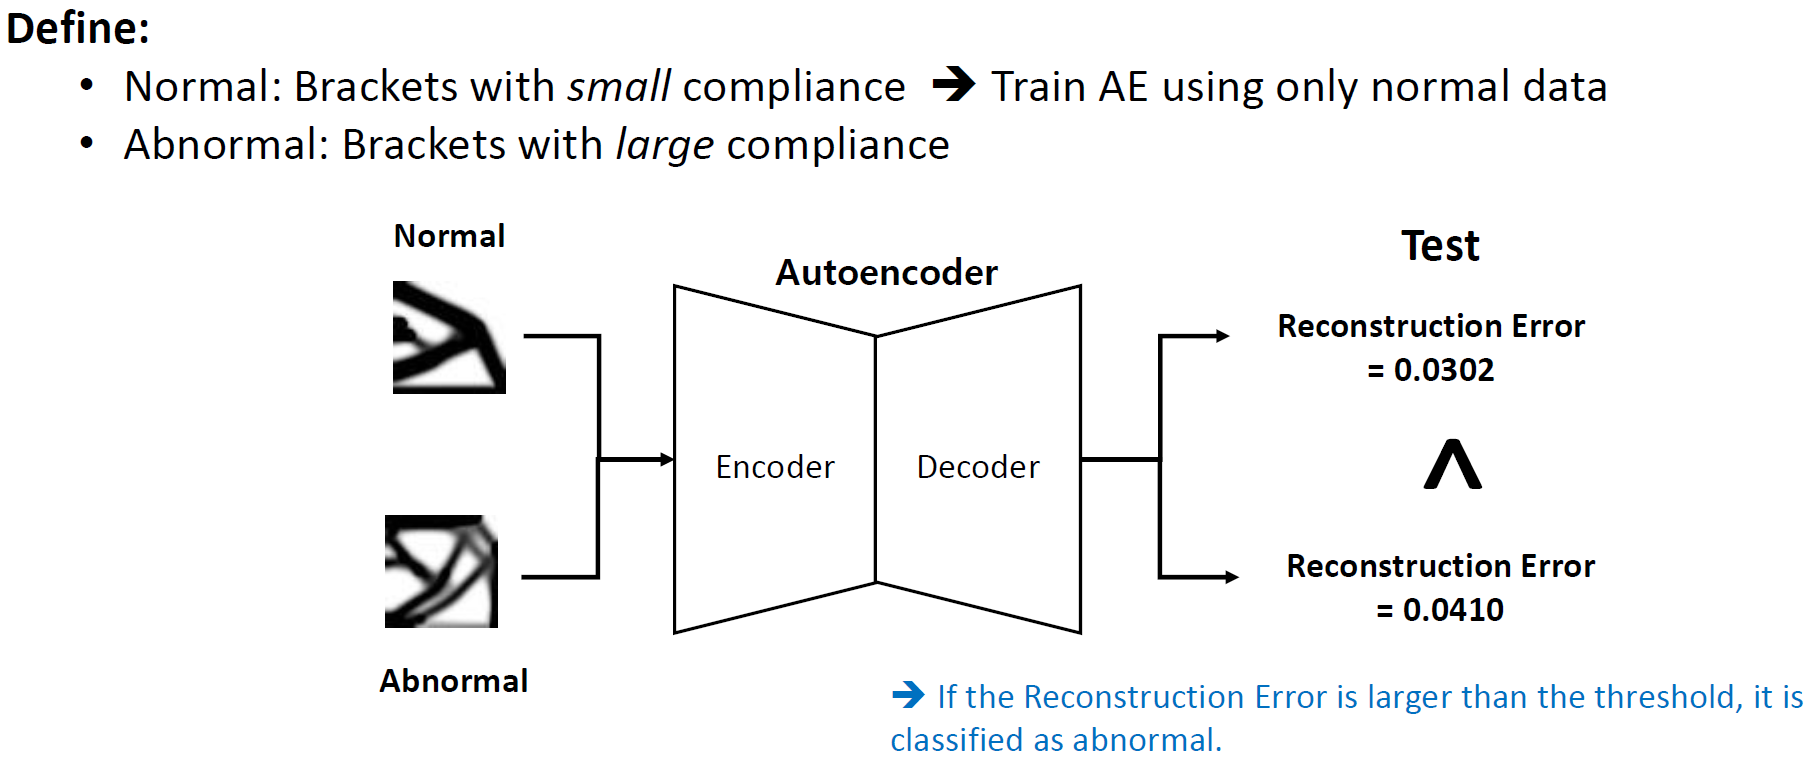

- Load abnormal dataset (data_1000.zip)

In [ ]:
# image size = 56 x 56, 1000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src_anom = './dataset/data_1000/'

anom_files = os.listdir(src_anom)  # get the list of files in the source directory

ANom,ANom_Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in anom_files:
    ANom.append(img_read(src_anom, file) / 255.)
    ANom_Y.append(0)  # abnormal label: 0

ANom = np.array(ANom)
ANom_Y = np.array(ANom_Y)

# reshape the (image,image) images into (image*image,) size vectors
ANom = ANom.reshape((len(ANom), np.prod(ANom.shape[1:]))).astype('float32')

# randomly select 600 indices from 1000 samples / equals to number of test dataset(600)
random_indices = np.random.choice(len(ANom), 600, replace=False)

# select the 600 random samples
ANom = ANom[random_indices]
ANom_Y = ANom_Y[random_indices]

print("Datasets_anomaly_shape:{}".format(np.shape(ANom)))

- Reconstruction of the test and anomaly data

In [ ]:
# convert data to PyTorch tensors
ANom_images = torch.tensor(ANom, dtype=torch.float32).to(device)

autoencoder.eval()

reconstructed_test = autoencoder(test_images)
reconstructed_anom = autoencoder(ANom_images)

- Compare the orginial image and the reconstructed image / abnormal dataset

In [ ]:
# proceed reconstruction of the bracket images through the trained autoencoder model

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(ANom_images.cpu()[i].reshape(56, 56), cmap='gray')  # reshape the images to show
    plt.title(f"Input {i+1}")
    ax.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_anom.detach().cpu()[i].reshape(56, 56), cmap='gray')  # reshape the images to show
    plt.title(f"Recon {i+1}")
    ax.axis('off')

plt.show()

- Visualize latent space using t-SNE (t-distributed Stochasstic Neighbor Embedding)

In [ ]:
# set the model to evaluation mode (no gradients will be computed)
autoencoder.eval()

with torch.no_grad():  # disable gradient computation for inference
    # get latent representations for normal and abnormal datasets
    z_test = autoencoder.encoder(test_images).cpu().detach().numpy()  # normal data
    z_anom = autoencoder.encoder(ANom_images).cpu().detach().numpy()  # abnormal data

# combine normal and abnormal latent vectors
z_combined = np.concatenate([z_test, z_anom])
labels_combined = np.concatenate([np.ones(len(z_test)), np.zeros(len(z_anom))])  # 1: Normal, 0: Abnormal

# apply t-SNE to reduce the latent space to 2 dimensions for visualization
tsne = TSNE(n_components=2, perplexity=40, random_state=0)
z_tsne = tsne.fit_transform(z_combined)

# create a scatter plot of the t-SNE results
plt.figure(figsize=(8, 8))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels_combined, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label='Data Label')
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Latent Space for Normal and Abnormal Data")
plt.show()

- Anomaly detection evaluation with metrics and confusion matrix

In [ ]:
# calculate MSE for normal and abnormal data
mse_test = torch.mean((test_images - reconstructed_test) ** 2, dim=1).detach().cpu().numpy()
mse_anom = torch.mean((ANom_images - reconstructed_anom) ** 2, dim=1).detach().cpu().numpy()

# set threshold for anomaly detection
threshold = 0.05  # adjust this threshold based on data

# classify based on MSE
y_pred_test = np.where(mse_test > threshold, 0, 1)  # 0 = abnormal, 1 = normal
y_pred_anom = np.where(mse_anom > threshold, 0, 1)

# combine test and anomaly predictions and true labels
y_pred = np.concatenate((y_pred_test, y_pred_anom))
y_true = np.concatenate((test_labels, ANom_Y))

In [ ]:
# confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

TP = conf_mat[0][0]  # both are Anomaly, 0 and the predicted value is positive (abnormal)
FN = conf_mat[0][1]  # the actual and predicted values differ, and the predicted value is negative (normal)
FP = conf_mat[1][0]  # the actual and predicted values differ, and the predicted value is positive (abnormal)
TN = conf_mat[1][1]  # both are Normal, 1 and the predicted value is negative (normal)

accuracy = (TP + TN) / (TP + FN + FP + TN)
error_rate = (FP + FN) / (TP + FN + FP + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Accuracy: {accuracy:.2%}")
print(f"Error Rate: {error_rate:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")

In [ ]:
# plot confusion matrix
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Anomaly(0)', 'Normal(1)'])
plt.yticks([0, 1], ['Anomaly(0)', 'Normal(1)'])
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_mat[i, j], ha="center", va="center", color="red")
plt.show()